In [1]:
import os
from pathlib import Path
project_root = os.path.join('/home/shashank/research/qd/main/diffusion_models')
os.chdir(project_root)
%pwd # should be PPGA root dir

'/home/shashank/research/qd/main/diffusion_models'

In [2]:
import torch
import pickle
import json
import numpy as np
import matplotlib
matplotlib.rcParams.update(
    {
        "figure.dpi": 150,
        "font.size": 20,
    }
)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
import matplotlib.pyplot as plt

from typing import Optional
from diffusion.gaussian_diffusion import cosine_beta_schedule, linear_beta_schedule, GaussianDiffusion
from diffusion.latent_diffusion import LatentDiffusion
from diffusion.ddim import DDIMSampler
from autoencoders.policy.hypernet import HypernetAutoEncoder as AutoEncoder
from dataset.shaped_elites_dataset import WeightNormalizer
from attrdict import AttrDict
from utils.tensor_dict import TensorDict, cat_tensordicts
from RL.actor_critic import Actor
from utils.normalize import ObsNormalizer
from models.cond_unet import ConditionalUNet, LangConditionalUNet
from envs.brax_custom.brax_env import make_vec_env_brax
from IPython.display import HTML, Image
from IPython.display import display
from brax.io import html, image
from utils.brax_utils import shared_params, rollout_many_agents

/home/shashank/miniconda3/envs/qd/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# params to config
device = torch.device('cuda')
env_name = 'humanoid'
seed = 1111
normalize_obs = True
normalize_rewards = False
obs_shape = shared_params[env_name]['obs_dim']
action_shape = np.array([shared_params[env_name]['action_dim']])
mlp_shape = (128, 128, action_shape)

env_cfg = AttrDict({
    'env_name': env_name,
    'env_batch_size': None,
    'num_dims': 2,
    'seed': seed,
    'num_envs': 1,
    'clip_obs_rew': True,
})

In [4]:
archive_df_path = f'data/{env_name}/archive100x100.pkl'
with open(archive_df_path, 'rb') as f:
    archive_df = pickle.load(f)

# scheduler_path = f'data/{env_name}/scheduler_100x100.pkl'
# with open(scheduler_path, 'rb') as f:
#     scheduler = pickle.load(f)

In [5]:
# make the env
env = make_vec_env_brax(env_cfg)

In [6]:
def enjoy_brax(agent, render=True, deterministic=True):
    if normalize_obs:
        obs_mean, obs_var = agent.obs_normalizer.obs_rms.mean, agent.obs_normalizer.obs_rms.var
        print(f'Normalize Obs Enabled')

    obs = env.reset()
    rollout = [env.unwrapped._state]
    total_reward = 0
    measures = torch.zeros(env_cfg.num_dims).to(device)
    done = False
    while not done:
        with torch.no_grad():
            obs = obs.unsqueeze(dim=0).to(device)
            if normalize_obs:
                obs = (obs - obs_mean) / torch.sqrt(obs_var + 1e-8)

            if deterministic:
                act = agent.actor_mean(obs)
            else:
                act, _, _ = agent.get_action(obs)
            act = act.squeeze()
            obs, rew, done, info = env.step(act.cpu())
            measures += info['measures']
            rollout.append(env.unwrapped._state)
            total_reward += rew
    if render:
        i = HTML(html.render(env.unwrapped._env.sys, [s.qp for s in rollout]))
        display(i)
    print(f'{total_reward=}')
    print(f' Rollout length: {len(rollout)}')
    measures /= len(rollout)
    print(f'Measures: {measures.cpu().numpy()}')
    return total_reward.detach().cpu(), measures.detach().cpu()

In [7]:
# diffusion model params
latent_diffusion = True
use_ddim = True
center_data = True
use_language = False
latent_channels = 4
latent_size = 4
timesteps = 600

cfg_path = '/home/shashank/research/qd/paper_results2/humanoid/diffusion_model/humanoid_diffusion_model_20230505-103651_333/args.json'
with open(cfg_path, 'r') as f:
    cfg = json.load(f)
    cfg = AttrDict(cfg)

scale_factor = cfg.scale_factor if latent_diffusion else None

device = 'cuda' if torch.cuda.is_available() else 'cpu'

betas = cosine_beta_schedule(timesteps)

In [8]:
# paths to VAE and diffusion model checkpoint
autoencoder_path = '/home/shashank/research/qd/paper_results2/humanoid/autoencoder/humanoid_autoencoder_20230503-082033_333/model_checkpoints/humanoid_autoencoder_20230503-082033_333.pt'
model_path = '/home/shashank/research/qd/paper_results2/humanoid/diffusion_model/humanoid_diffusion_model_20230505-103651_333/model_checkpoints/humanoid_diffusion_model_20230505-103651_333.pt'
weight_normalizer_path = 'results/humanoid/weight_normalizer.pkl'

In [9]:
# load the diffusion model
logvar = torch.full(fill_value=0., size=(timesteps,))
if use_language:
    model = LangConditionalUNet(
        in_channels=latent_channels,
        out_channels=latent_channels,
        channels=64,
        n_res_blocks=1,
        attention_levels=[],
        channel_multipliers=[1, 2, 4],
        n_heads=4,
        d_cond=256,
        logvar=logvar,
        language_model='flan-t5-small'
    )
else:
    model = ConditionalUNet(
        in_channels=latent_channels,
        out_channels=latent_channels,
        channels=64,
        n_res_blocks=1,
        attention_levels=[],
        channel_multipliers=[1, 2, 4],
        n_heads=4,
        d_cond=256,
        logvar=logvar
    )
autoencoder = AutoEncoder(emb_channels=4,
                          z_channels=4,
                          obs_shape=obs_shape,
                          action_shape=action_shape,
                          z_height=4,
                          enc_fc_hid=64,
                          obsnorm_hid=64,
                          ghn_hid=32)
autoencoder.load_state_dict(torch.load(autoencoder_path))
autoencoder.to(device)
autoencoder.eval()

gauss_diff = LatentDiffusion(betas, num_timesteps=timesteps, device=device)
model.load_state_dict(torch.load(model_path))
model.to(device)

weight_normalizer = None
if center_data:
    weight_normalizer = WeightNormalizer(TensorDict({}), TensorDict({}))
    weight_normalizer.load(weight_normalizer_path)


Total size of z is: 64


In [10]:
def postprocess_agents(rec_agents: list[Actor], obsnorms: list[dict]):
    '''Denormalize outputs of the decoder and return a list of Actors that can be rolled out'''
    batch_size = len(rec_agents)
    TensorDict(obsnorms)
    rec_agents_params = [TensorDict(p.state_dict()) for p in rec_agents]
    rec_agents_params = cat_tensordicts(rec_agents_params)
    rec_agents_params.update(obsnorms)
    # decoder doesn't fill in the logstd param, so we manually set it to default values
    actor_logstd = torch.zeros(batch_size, 1, action_shape[0])
    actor_logstd = actor_logstd.to(device)
    rec_agents_params['actor_logstd'] = actor_logstd
    # if data centering was used during training, we need to denormalize the weights
    if center_data:
        rec_agents_params = weight_normalizer.denormalize(rec_agents_params)

    if normalize_obs:
        rec_agents_params['obs_normalizer.obs_rms.var'] = torch.exp(rec_agents_params['obs_normalizer.obs_rms.logstd'] * 2)
        rec_agents_params['obs_normalizer.obs_rms.count'] = torch.zeros(batch_size, 1).to(device)
        del rec_agents_params['obs_normalizer.obs_rms.logstd']

    rec_agents = [Actor(obs_shape, action_shape, normalize_obs=normalize_obs).to(device) for _ in range(len(rec_agents_params))]
    for i in range(len(rec_agents_params)):
        rec_agents[i].load_state_dict(rec_agents_params[i])

    return rec_agents

In [11]:
ddim_sampler = DDIMSampler(gauss_diff, n_steps=100)

In [12]:
def get_agent_with_measure(m):
    batch_size = 1
    if isinstance(m, list):
        cond = torch.Tensor(m).view(1, -1).to(device)
    elif isinstance(m, torch.Tensor):
        cond = m.view(1, -1).to(device)

    shape = [batch_size, latent_channels, latent_size, latent_size]
    samples = ddim_sampler.sample(model, shape=shape, cond=cond, classifier_free_guidance=True, classifier_scale=1.0)
    samples = samples * (1 / scale_factor)
    (rec_agents, obsnorms) = autoencoder.decode(samples)
    rec_agents = postprocess_agents(rec_agents, obsnorms)
    return rec_agents[0]

In [13]:
def get_agent_with_text(t: str):
    batch_size = 1
    cond = model.text_to_cond([t])
    shape = [batch_size, latent_channels, latent_size, latent_size]
    samples = ddim_sampler.sample(model, shape=shape, cond=cond, classifier_free_guidance=True, classifier_scale=1.0)
    samples = samples * (1 / scale_factor)
    (rec_agents, obsnorms) = autoencoder.decode(samples)
    rec_agents = postprocess_agents(rec_agents, obsnorms)
    return rec_agents[0]

In [14]:
batch_size = 1
cond = torch.ones((batch_size, 2)) * 0.2
cond = cond.to(device)

In [15]:
shape = [batch_size, latent_channels, latent_size, latent_size]
samples = ddim_sampler.sample(model, shape=shape, cond=cond, classifier_free_guidance=True, classifier_scale=2.0)
samples = samples * (1 / scale_factor)
(rec_agents, obsnorms) = autoencoder.decode(samples)
rec_agents = postprocess_agents(rec_agents, obsnorms)

In [16]:
# random_idx = torch.randint(0, batch_size, (1,))
# print(f'{random_idx=}')
# print(len(obsnorms))
# rec_agent = rec_agents[random_idx]
# rec_agent = get_agent_with_measure([0.5, 0.5])

# text =   "run forward on your left foot while lifting your right foot"
# rec_agent = get_agent_with_text(text)
# enjoy_brax(rec_agent)

In [17]:
# evaluate an agent on many envs in parallel
N = 50
multi_env_cfg = AttrDict({
    'env_name': env_name,
    'env_batch_size': N,
    'num_envs': N,
    'num_dims': 2,
    'seed': seed,
    'clip_obs_rew': True,
})
multi_vec_env = make_vec_env_brax(multi_env_cfg)

In [18]:
# rollout_many_agents([rec_agent], multi_env_cfg, multi_vec_env, device, verbose=True, normalize_obs=True)

In [19]:
def compose_behaviors(env, device, measures: Optional[torch.Tensor] = None, labels: Optional[list[str]] = None,
                      num_envs: int = 1, deterministic: bool = True, render: bool = True):
    if num_envs > 1:
        render = False
    agents = []
    assert measures is not None or labels is not None
    if measures is not None:
        for m in measures:
            agent = get_agent_with_measure(m)
            agents.append(agent)
    else:
        for l in labels:
            agent = get_agent_with_text(l)
            agents.append(agent)

    num_chunks = len(agents)

    # https://stackoverflow.com/questions/2130016/splitting-a-list-into-n-parts-of-approximately-equal-length
    def split(a, n):
        k, m = divmod(len(a), n)
        return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

    time_intervals = list(split(np.arange(0, 1000), num_chunks))

    num_steps = 1000
    total_reward = torch.zeros(num_envs)
    dones = torch.BoolTensor([False for _ in range(num_envs)]).to(device)
    all_dones = torch.zeros((num_steps, num_envs)).to(device)
    # get the per-chunk measures independent of other chunks
    measure_data = [[] for _ in range(num_chunks)]

    obs = env.reset()
    rollout = [env.unwrapped._state]

    t = 0
    while not torch.all(dones):
        interval_idx = next((i for i, interval in enumerate(time_intervals) if t in interval), None)
        agent = agents[interval_idx]
        obs_mean, obs_var = agent.obs_normalizer.obs_rms.mean, agent.obs_normalizer.obs_rms.var

        obs = (obs - obs_mean) / torch.sqrt(obs_var + 1e-8)

        if deterministic:
                act = agent.actor_mean(obs)
        else:
            act, _, _ = agent.get_action(obs)
        act = act.squeeze()
        obs, rew, next_dones, info = env.step(act.cpu())
        measure_t = info['measures'].mean(0)
        measure_data[interval_idx].append(measure_t.detach().cpu().numpy())
        if num_envs == 1:
            rollout.append(env.unwrapped._state)
        total_reward += rew.detach().cpu().numpy() * ~dones.cpu().numpy()
        dones = torch.logical_or(dones, next_dones)
        all_dones[t] = dones.long().clone()
        t += 1
    if render:
        i = HTML(html.render(env.unwrapped._env.sys, [s.qp for s in rollout]))
        display(i)

    # the first done in each env is where that trajectory ends
    traj_lengths = torch.argmax(all_dones, dim=0) + 1

    print(f'Total Reward: {total_reward.mean().item()}, Average Trajectory Length: {traj_lengths.float().mean().item()}')
    return measure_data, total_reward.mean().item(), traj_lengths.float().mean().item()

In [20]:
measures = [
    [0.9, 0.9],
    [0.2, 0.2],
    [0.5, 0.0],
    [0.0, 0.5]
]
labels = [
    "quickly slide forward on right foot",
    "quickly run forward using only your left foot",
    "quickly walk forward while dragging your right foot",
    "skip forwards on your right foot"
]
# measure_data, *_ = compose_behaviors(multi_vec_env, device, labels=labels, num_envs=multi_env_cfg.num_envs, render=False)


In [21]:
list_ov_moving_avg = []
avg_traj_lengths = []
for k in range(20):
    measure_data, reward, traj_len = compose_behaviors(multi_vec_env, device, measures=measures, num_envs=multi_env_cfg.num_envs, render=False)

    # get the avg measure for each time interval independent of the other ones. Sanity check
    interval_measures = []
    for ms in measure_data:
        ms = np.mean(np.array(ms), axis=0)
        interval_measures.append(ms)
    print(f'{interval_measures=}')

    # get the moving average measures
    window_size = 50
    moving_averages = []
    all_measure_data = np.concatenate(measure_data)
    t = 0
    while t < len(all_measure_data) - window_size + 1:
        window_average = np.sum(all_measure_data[t: t + window_size], axis=0) / window_size
        moving_averages.append(window_average)
        t += 1
    moving_averages = np.array(moving_averages)
    list_ov_moving_avg.append(moving_averages)
    avg_traj_lengths.append(traj_len)
    
successes = [1 if x > 800 else 0 for x in avg_traj_lengths]
success_rate = np.mean(successes)
print(f'{success_rate=}')

Total Reward: 7995.443359375, Average Trajectory Length: 898.1199951171875
interval_measures=[array([0.83280015, 0.74496   ], dtype=float32), array([0.1084801 , 0.38519982], dtype=float32), array([0.44519994, 0.03928006], dtype=float32), array([0.19879997, 0.40911996], dtype=float32)]
Total Reward: 6785.5126953125, Average Trajectory Length: 792.4199829101562
interval_measures=[array([0.8532801 , 0.74712026], dtype=float32), array([0.10880006, 0.44223997], dtype=float32), array([0.47640005, 0.01287999], dtype=float32), array([0.16384025, 0.3780798 ], dtype=float32)]
Total Reward: 7358.36865234375, Average Trajectory Length: 846.4599609375
interval_measures=[array([0.8648804, 0.7020799], dtype=float32), array([0.13872007, 0.25544006], dtype=float32), array([0.44616005, 0.06392018], dtype=float32), array([0.18136014, 0.40944022], dtype=float32)]
Total Reward: 5702.1494140625, Average Trajectory Length: 663.2799682617188
interval_measures=[array([0.81320024, 0.79511994], dtype=float32), a

In [22]:
# make all the moving averages the same length
max_len = max([len(m) for m in list_ov_moving_avg])
for i in range(len(list_ov_moving_avg)):
    m = list_ov_moving_avg[i]
    if len(m) < max_len:
        padding = np.zeros((max_len - len(m), 2))
        list_ov_moving_avg[i] = np.concatenate([m, padding])

moving_averages_mean = np.mean(np.array(list_ov_moving_avg), axis=0)
moving_averages_std = np.std(np.array(list_ov_moving_avg), axis=0)

In [23]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))
time_intervals = list(split(np.arange(0, 1000), 4))
desired_measures = np.concatenate([np.array([measure]).repeat(len(time_intervals[ind]),0) for ind, measure in enumerate(measures)])
print(desired_measures)

[[0.9 0.9]
 [0.9 0.9]
 [0.9 0.9]
 ...
 [0.  0.5]
 [0.  0.5]
 [0.  0.5]]


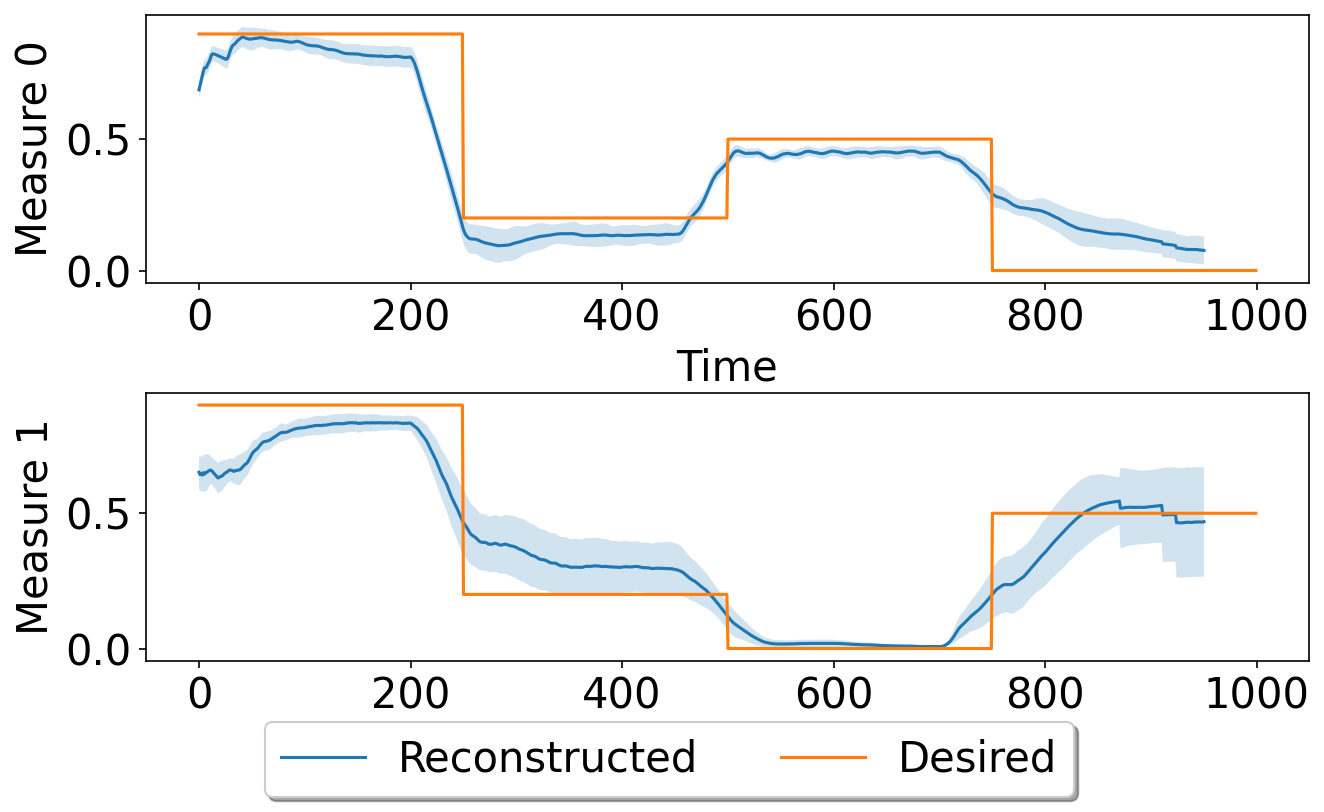

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
# plot reconstructed measures
# ax1.plot(np.arange(0, len(moving_averages)), [moving_averages[i][0] for i in range(len(moving_averages))], label='Reconstructed')
# ax2.plot(np.arange(0, len(moving_averages)), [moving_averages[i][1] for i in range(len(moving_averages))], label='Reconstructed')
ax1.plot(np.arange(0, len(moving_averages_mean)), [moving_averages_mean[i][0] for i in range(len(moving_averages_mean))], label='Reconstructed')
ax1.fill_between(np.arange(0, len(moving_averages_mean)), moving_averages_mean[:, 0] - moving_averages_std[:, 0], moving_averages_mean[:, 0] + moving_averages_std[:, 0], alpha=0.2)
ax2.plot(np.arange(0, len(moving_averages_mean)), [moving_averages_mean[i][1] for i in range(len(moving_averages_mean))], label='Reconstructed')
ax2.fill_between(np.arange(0, len(moving_averages_mean)), moving_averages_mean[:, 1] - moving_averages_std[:, 1], moving_averages_mean[:, 1] + moving_averages_std[:, 1], alpha=0.2)



ax1.plot(np.arange(0, len(desired_measures)), [desired_measures[i][0] for i in range(len(desired_measures))], label='Desired')
ax2.plot(np.arange(0, len(desired_measures)), [desired_measures[i][1] for i in range(len(desired_measures))], label='Desired')

ax1.set_ylabel('Measure 0')
ax2.set_ylabel('Measure 1')

ax1.set_xlabel('Time')
ax2.set_xlabel('Time')

# ax1.legend()
ax2.legend()
# Shrink current axis's height by 10% on the bottom
box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.15,
                 box.width, box.height * 0.85])
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.15,
                 box.width, box.height * 0.85])

# Put a legend below current axis
ax2.legend(loc='upper center', bbox_to_anchor=(0.45, -0.15),
          fancybox=True, shadow=True, ncol=5)




In [ ]:
def behavior_composition_experiments(N: int = 20):
    '''Run N behavior composition experiments and report the results'''
    avg_rewards, avg_traj_lengths = [], []
    for n in range(N):
        measures = torch.rand((4, 2))
        print(f'Measures: {measures}')
        _, avg_rew, avg_traj_len = compose_behaviors(measures, multi_vec_env, device, multi_env_cfg.num_envs)
        avg_rewards.append(avg_rew),
        avg_traj_lengths.append(avg_traj_len)
        print(f'Completed trial {n + 1} of {N}')
    successes = [1 if x > 800 else 0 for x in avg_traj_lengths]
    success_rate = np.mean(successes)
    print(avg_rewards)
    print(avg_traj_lengths)
    print(success_rate)

In [ ]:
behavior_composition_experiments()